In [1]:
import csv
import datetime
import glob
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import integrate
from scipy.signal import medfilt
from scipy.signal import find_peaks
from scipy.signal import correlate

**Preprocess the data**

*load data*

In [2]:
# Issues:
# Integrate calibration or load SCALE_X and SCALE_Y directly
# Calculation of the rotation angle derived from binary_angle_code not working, 12bit (4096 Values) ???
# Influence of x_int ... the intersection of the slope with the bottom line of the turning plat is 
# strong and should be investigated more


main_path = r"C:\Users\knut\Nextcloud\Geotechnik-Freigaben\Dienstleistung\Versuche_FuE\F_05_Schüttkegel_Anton\Versuche"
psd = r"SP-4-A"
subset = r"SP-4-A-1"
trial = 1

folder = os.path.join(main_path,psd, subset, str(trial))
z_files = glob.glob(os.path.join(folder, "*_Z_*.npy"))
lumi_files = glob.glob(os.path.join(folder, "*_LUMI_*.npy"))
Info_files = glob.glob(os.path.join(folder, "*_Info_*"))

#os.path.join(main_path, subset, str(trial),f"*_Z_*.npy")

#calib_center_lumi = np.load(r"C:\Users\knut\Nextcloud\Geotechnik-Freigaben\Dienstleistung\Versuche_FuE\F_05_Schüttkegel_Anton\Kalibrierung_mitMaß\lumi_20250825_141755.npy")
#calib_center_z = np.load(r"C:\Users\knut\Nextcloud\Geotechnik-Freigaben\Dienstleistung\Versuche_FuE\F_05_Schüttkegel_Anton\Kalibrierung_mitMaß\z_20250825_141755.npy")
#calib_z = np.load(r"C:\Users\knut\Nextcloud\Geotechnik-Freigaben\Dienstleistung\Versuche_FuE\F_05_Schüttkegel_Anton\Kalibrierung_leerfahrt\z_20250825_140258.npy")
if z_files:
    z_data = np.load(z_files[0])
    z_data = z_data.astype(float)
else:
    print("No Z file found.")

if lumi_files:
    lumi_data = np.load(lumi_files[0])
    lumi_data = lumi_data.astype(float)
else:
    print("No LUMI file found.")

if Info_files:
    with open(Info_files[0], 'r', encoding='utf-8') as file:
        # Lies alle Zeilen der Datei in eine Liste
        lines = file.readlines()
for line in lines:
    line = line.strip()
    match = re.findall(r"\d+,\d+", line)
    if match:
        number_str = match[0].replace(',', '.')
        dry_mass = float(number_str)
    # Mach etwas mit der Zeile
    print(dry_mass, line)

SCALE_Z = 0.004013243704223939 #derived by kalibrierung.ipynb 
SCALE_X = 0.050225457194533765 #derived by kalibrierung.ipynb
GRADIENT_TILT = -0.1590503214142255 #derived by kalibrierung.ipynb | to correct the tilt of the laser

665.12 Masse der Probe ist: 665,12 g


**Preprocess Data**

*vanish outliers in z-Data*

In [3]:
q1 = np.quantile(z_data,0.25,axis=0)
q3 = np.quantile(z_data,0.75,axis=0)
iqr_local = q3-q1
lower_bound = q1 - 1.5*iqr_local
upper_bound = q3 + 1.5*iqr_local
outliers = (z_data < lower_bound) | (z_data > upper_bound)
valid = ~outliers

*Median filter the data*

In [4]:
KERNELSIZE_LUMI = 5
KERNELSIZE_Z = 3

# truncate data which exceed 13000 values
if z_data.shape[1] > 13000:
    z_data = z_data[:,:13000]
if lumi_data.shape[1] > 13000:
    lumi_data = lumi_data[:,:13000]
# Convert to object scale
# filter lumi data by moving median in 2D
lumi_data_f = np.zeros(np.shape(lumi_data))
for i in range(lumi_data_f.shape[0]):
    lumi_data_f[i,:-1] = medfilt(lumi_data[i,:-1],KERNELSIZE_LUMI)
for j in range(lumi_data.shape[1]):
    lumi_data_f[:-1,j] = medfilt(lumi_data_f[:-1,j],KERNELSIZE_LUMI)
#
#
# filter z-data by moving median in 2D
z_data_f = np.copy(z_data)
for i in range(z_data_f.shape[0]):
    to_filter = z_data[valid[:,i],i]
    z_data_f[valid[:,i],i] = medfilt(to_filter,KERNELSIZE_Z)


# truncate last column to avoid edge effects of the median filter
z_data_f = z_data_f[:,:-1]
lumi_data_f = lumi_data_f[:,:-1]
x_data_f = np.linspace(0,len(z_data_f),len(z_data_f))
x_data = np.linspace(0,len(z_data),len(z_data))

*find rotation center*

*Calculationg a linear regression on each side of the cone and utilze the intersection point*

In [5]:
INNERCENTEROFFSET = 30 # offset from the center to start the search for the inner edge
OUTERCENTEROFFSET = 200 # offset from the center to start the search for the outer edge
x_int = np.zeros(np.shape(z_data_f)[1])
index_max_z = np.zeros(np.shape(z_data_f)[1],dtype=int)
index_max_z = np.median(np.nanargmax(z_data_f,axis=0))
index_max_z = int(index_max_z)
for i in range(np.shape(z_data_f)[1]):
    # define left and right fit ranges
    first_valid = np.argmax(valid[:,i])
    left_start = max(first_valid, int(index_max_z-OUTERCENTEROFFSET))
    left_stop = max(0, int(index_max_z-INNERCENTEROFFSET))
    right_start = min(z_data_f.shape[0], int(index_max_z+INNERCENTEROFFSET))
    right_stop = min(z_data_f.shape[0], int(index_max_z+OUTERCENTEROFFSET))
    # define row ranges for left and right linear fits
    row_range_left = slice(left_start, left_stop)
    row_range_right = slice(right_start, right_stop)
    # define a mask to omit nan within the interpolation
    mask_left = valid[left_start:left_stop,i]
    mask_right = valid[right_start:right_stop,i]
    # linear fit left and right of the peak
    x_data_extracted_left = x_data[row_range_left][mask_left]
    z_data_extracted_left = z_data_f[row_range_left,i][mask_left]
    x_data_extracted_right = x_data[row_range_right][mask_right]
    z_data_extracted_right = z_data_f[row_range_right,i][mask_right]
    # calculate a linear interpolation left and right 
    m_left, b_left = np.polyfit(x_data_extracted_left, z_data_extracted_left, 1)
    m_right, b_right = np.polyfit(x_data_extracted_right, z_data_extracted_right, 1)
    x_int[i] = (b_right - b_left) / (m_left - m_right)
x_int = x_int.astype(int)
print(f"Median of intersection points: {np.median(x_int*SCALE_X):.1f} mm +- {np.std(x_int*SCALE_X):.1f} mm")

Median of intersection points: 14.9 mm +- 0.5 mm


**correlate the signal to find repeated scans**

Signal repeats at index:, 1441 the data is truncated to 8942 scans


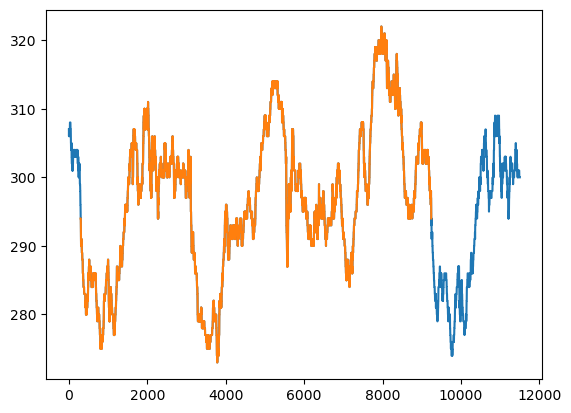

In [94]:
OFFSET = 300 # Scans skiped at the beginning to avoid edge effects
LASTINDEX = 4000 # last scans, the repeat should be found in

y = x_int.astype(float)
y1 = (y-np.mean(y[:-1]))/np.std(y[:-1])
y2 = (y-np.mean(y[:-1]))/np.std(y[:-1])
autocorr = correlate(y1,y2, mode='full')
lags = np.arange(-len(y1)+1, len(y1))

# Only look at positive lags (right half)
autocorr_pos = autocorr[len(y1)-1:]
lags_pos = lags[len(y1)-1:]
# Find the first peak after lag 0
peaks = np.nan
peaks = np.argmax(autocorr_pos[-LASTINDEX:])
if not np.isnan(peaks):
    repeat_index = lags_pos[peaks]  # first peak after lag 0
    lstart = 0+OFFSET
    lend = len(x_int)-LASTINDEX+repeat_index+OFFSET
    print(f"Signal repeats at index:, {repeat_index} the data is truncated to {lend-lstart} scans")
    #truncate 2D-arrays
    x_temp = np.linspace(0,len(x_int),len(x_int))
    plt.plot(x_temp, x_int)
    lumi_data_t = lumi_data[:,lstart:lend]
    lumi_data_f_t = lumi_data_f[:,lstart:lend]
    z_data_t = z_data[:,lstart:lend]
    z_data_f_t = z_data_f[:,lstart:lend]
    valid_t = valid[:,lstart:lend]
    x_int_t = x_int[lstart:lend]
    plt.plot(x_temp[lstart:lend], x_int_t)
    plt.show()
else:
    print("No repeat found.")

**Rotate, shift, truncate and scale z-Data and lumi data** <br>
*Rotate and shift in x direction*

In [25]:
SAMPLESIZE = 2500 # number of samples in x direction for the final data set
x_data_f_r_s = np.linspace(0,SAMPLESIZE,SAMPLESIZE)

# rotate data
diff = GRADIENT_TILT*z_data_f_t.shape[0]
rot_y = np.linspace(0, diff, z_data_f_t.shape[0])
z_data_f_r = z_data_f_t - rot_y[:, None]

#x-Shift and trunc data in x direction
z_data_f_r_sx = np.zeros((SAMPLESIZE,np.shape(z_data_f_r)[1]))    
lumi_data_f_sx = np.zeros((SAMPLESIZE,np.shape(lumi_data_f)[1]))
valid_s = np.zeros((SAMPLESIZE,np.shape(valid_t)[1]),dtype=bool)
for i in range(np.shape(z_data_f_r)[1]):
    valid_s[:,i] = np.astype(valid_t[x_int[i]:x_int[i]+SAMPLESIZE,i],np.bool)
    z_data_f_r_sx[:,i] = z_data_f_r[x_int[i]:x_int[i]+SAMPLESIZE,i]
    lumi_data_f_sx[:,i] = lumi_data_f[x_int[i]:x_int[i]+SAMPLESIZE,i]

*Find the intersection of the slope with the plate*

In [96]:
RIGHTSTART = 2000 #left edge for the calculation of the level of the plate
RIGHTSTOP = 2500 #right edge for the calculation of the level of the plate
MAXTHRESHOLD = 1.05 #Threshold to find a value biger then the maximum of the plate
LEFTOFFSET = 500 #Samples used to calculate the linear interpolation along the slope
x_int_floor = np.zeros(np.shape(z_data_f_r_sx)[1])
z_data_f_r_sx_sz = np.zeros((SAMPLESIZE,np.shape(z_data_f_r_sx)[1]))
b_right = np.zeros(x_int_floor.shape)
for i in range(np.shape(z_data_f_t)[1]):
    # define left and right fit ranges
    # define row ranges for left and right linear fits
    right_stop = min(z_data_f_r_sx.shape[0], RIGHTSTOP)
    row_range_right = slice(RIGHTSTART, right_stop)
    # linear fit left and right of the peak
    b_right[i] = np.min(z_data_f_r_sx[row_range_right,i])
    #adaptive calculate the row range left
    max_right = np.max(z_data_f_r_sx[row_range_right,i])
    left_stop = np.where(z_data_f_r_sx[:RIGHTSTART,i] > MAXTHRESHOLD*max_right)[0][-1]
    left_start = left_stop - LEFTOFFSET
    row_range_left = slice(left_start, left_stop)
    m_left, b_left = np.polyfit(x_data_f_r_s[row_range_left], z_data_f_r_sx[row_range_left,i], 1)
    x_int_floor[i] = (b_right[i] - b_left) / (m_left)
print(f"Median of radius: {np.median(x_int_floor*SCALE_X):.1f} mm +- {np.std(x_int_floor*SCALE_X):.1f} mm")
x_int_floor = x_int_floor.astype(int)

# z-Shift by floor intersection 
# 2025/09/10 changed. Minimum value calculated with b_right is now used for the calculation of the z-Shift
#z_shift = np.zeros(x_int_floor.shape)
for i in range(np.shape(z_data_f_r_sx_sz)[1]):
    #z_shift[i] = z_data_f_r_sx[x_int_floor[i],i]
    z_data_f_r_sx_sz[:,i] = z_data_f_r_sx[:,i]-b_right[i]

Median of radius: 89.6 mm +- 2.1 mm


In [ ]:
# STARTSAMPLE = 2000
# SAMPLE = 6000
# STEPSIZE = 1000
# plt.plot(z_data_f_r_sx[:,STARTSAMPLE:SAMPLE:STEPSIZE])
# for x in x_int_floor[STARTSAMPLE:SAMPLE:STEPSIZE]:
#     plt.axvline(x)
# for y in z_shift[STARTSAMPLE:SAMPLE:STEPSIZE]:
#     plt.axhline(y)
# plt.show()

*convert to object scale*

In [80]:
# Convert to object scale
z_data_f_r_s_obj = z_data_f_r_sx_sz*SCALE_Z
x_data_f_r_s_obj = np.linspace(0,SCALE_X*len(z_data_f_r_sx_sz),len(z_data_f_r_sx_sz))

**Calculate the angle of rotation with the binary code** (not executed)

In [39]:
# Issue, transformation of the 12 bit binary works, results are not plausible

# LUMISTART = 1910 # start index of the estimation of the binary mask
# LUMIOFFSET = 25  # offset to the start index
# LUMISTEP = 50 # step width of the binary mask

# lumi_mask = np.zeros(np.shape(lumi_data_f_s))
# for j in range(lumi_data_f_s.shape[1]):
#     lumi_max = np.max(lumi_data_f_s[2200:-1,j])
#     lumi_mean = np.mean(lumi_data_f_s[2200:-1,j])
#     lumi_mask[:-1,j] = np.where((lumi_data_f_s[:-1,j] >= 600), 1, 0)

# binary_angle_code = np.zeros((12,np.shape(lumi_data_f_s)[1]))
# for i in range(lumi_mask.shape[1]):
#     for j in range(binary_angle_code.shape[0]):
#         # sum all elements within the window to check for a binary 1
#         lumi_mask_binary_sum = np.sum(lumi_mask[LUMISTART+LUMIOFFSET+(j-1)*LUMISTEP:LUMISTART+LUMIOFFSET+j*LUMISTEP,i])
#         if lumi_mask_binary_sum >= 0.7*LUMISTEP:
#             binary_angle_code[j,i] = 1

# rotation_angle = np.zeros((np.shape(binary_angle_code)[1]))
# for i in range(np.shape(rotation_angle)[0]):
#     rotation_angle[i] = binary_array_to_decimal(binary_angle_code[:,i])
# plt.plot(rotation_angle)
# plt.show()

**Calculate Cone Volume**

*Procedure 1: mean radius and mean height* <br>
$V_{c,geo} = \frac{1}{3} \pi \bar{r}^2 \bar{h}$ <br>

In [81]:
r_mean = np.mean(x_data_f_r_s_obj[x_int_floor])
h_mean = np.mean(z_data_f_r_s_obj[0,:])
v_cone_geometrical = (1/3)*np.pi*r_mean*r_mean*h_mean
print(f"Geometrisches Volumen des Kegels: {v_cone_geometrical/1000:.1f} cm³")

Geometrisches Volumen des Kegels: 499.1 cm³


*Procedure 2: derived by the mean area* <br>
$V_{c,area} = \bar{A} \frac{2}{3} \pi \bar{r}$ <br>
with: <br>
$\bar{A} = \frac{1}{N}\sum_{1}^{N} A_i$ <br>
and: <br>
$A_i = \frac{z_{i-1}+z_i}{2}\left(x_{i-1}-x_i\right)$ (numerical integration using the trapeziodal rule)

In [82]:
area_local = np.zeros(np.shape(z_data_f_r_s_obj)[1])
for i in range(np.shape(z_data_f_r_s_obj)[1]):
    mask_valid = valid_s[0:x_int_floor[i],i]
    z_data_valid = z_data_f_r_s_obj[0:x_int_floor[i],i][mask_valid]
    x_data_valid = x_data_f_r_s_obj[0:x_int_floor[i]][mask_valid]
    area_local[i] = integrate.trapezoid(z_data_valid, x_data_valid)
area_mean = np.mean(area_local)
v_cone_area = area_mean*(2/3)*np.pi*r_mean
print(f"Volumen des Kegels über Flächenintegration mit mittleren Radius: {v_cone_area/1000:.1f} cm³")

Volumen des Kegels über Flächenintegration mit mittleren Radius: 537.4 cm³


*Procedure 3: integrating the cone area picewise*

In [83]:
h_map = np.linspace(0,np.max(z_data_f_r_s_obj),100)
poloar_coordinate = np.linspace(0,2*np.pi,np.shape(z_data_f_r_s_obj)[1])
diff_h_map = np.diff(h_map)[0]
diff_polar_coordinate = np.diff(poloar_coordinate)[0]
d_area = np.zeros(np.shape(z_data_f_r_s_obj)[1]-1)
d_v_cone_numeric = np.zeros(len(area_local))

v_cone_numeric = 0.0
for i in range(len(area_local)):
    ri = x_data_f_r_s_obj[x_int_floor[i]]
    v_cone_numeric += area_local[i] *diff_polar_coordinate*ri*(1/3)

print(f"Volumen des Kegels über numerische Integration mit diskretem Radius: {v_cone_numeric/1000:.1f} cm³")


Volumen des Kegels über numerische Integration mit diskretem Radius: 537.5 cm³


**Calculate the angle of repose**

In [93]:
def calculate_slope_angle(x, z,x_edge_left,x_edge_right,valid_mask, x_edge_offset,ANGLESINPROFILE=1):
    # x ... x-coordinates of the slope (n,1)
    # z ... z-coordinates of the slope (n,m)
    # x_edge_left ... left edge of the slope (n,1)
    # x_edge_right ... right edge of the slope (n,1)   
    # ANGLESINPROFILE ... number of angles calculated along each slope
    angle = np.zeros((np.shape(z)[1],ANGLESINPROFILE))
    ind_start = np.zeros((np.shape(z)[1],ANGLESINPROFILE), dtype=int)
    ind_stop = np.zeros((np.shape(z)[1],ANGLESINPROFILE), dtype=int)
    for i in range(np.shape(z)[1]):
        ind_length = int(x_edge_right[i]-x_edge_left[i]-2*x_edge_offset)
        ind_step = int(ind_length/ANGLESINPROFILE)
        for j in range(ANGLESINPROFILE):
            ind_start = int(x_edge_left[i]+x_edge_offset+(j)*ind_step)
            ind_stop = int(ind_start+ind_step)
            x_range = slice(ind_start, ind_stop)
            valid_ind = valid_mask[x_range,i] 
            x_valid = x[x_range][valid_ind]
            z_valid = z[x_range,j][valid_ind]
            m, _ = np.polyfit(x_valid, z_valid, 1)
            angle[i,j] = (-1)*np.degrees(np.arctan(m))
    return angle, ind_start, ind_stop

ANGLESINPROFILE = 1 # angles calculate along each slope

angle_local, ind_global_slope_start, ind_global_slope_end = calculate_slope_angle(
                x_data_f_r_s_obj, 
                z_data_f_r_s_obj,
                np.zeros(x_int_floor.shape), 
                x_int_floor,
                valid_s,
                100,
                ANGLESINPROFILE)
mean_angle = np.mean(angle_local)
std_angle = np.std(angle_local)

# calculate aditionaly several angles of repose along each slope
angle_local, ind_local_slope_start, ind_local_slope_end = calculate_slope_angle(
                x_data_f_r_s_obj, 
                z_data_f_r_s_obj,
                np.zeros(x_int_floor.shape), 
                x_int_floor,
                valid_s,
                100,
                5)
print(f"Mittlerer Neigungswinkel des Kegels: {mean_angle:.2f}° ± {std_angle:.2f}°")

Mittlerer Neigungswinkel des Kegels: 35.18° ± 0.19°


In [266]:
# Sample list of lines as an example
res_file_filename = f"{subset}_{str(trial)}_RES_{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}.csv"
res_file = os.path.join(folder,res_file_filename)
data = [ 
    ['dry mass' , 'md', dry_mass, 'g'],
    ['number of scans', 'n_scans', np.shape(z_data_f_r_s_obj)[1], ''],
    ['stadard deviation of x-Positon of cone center', 'std_x_int', np.std(x_int*SCALE_X), 'mm'],
    ['standard deviation of x-Positon of floor intersection', 'std_x_int_floor', np.std(x_int_floor*SCALE_X), 'mm'],
    ['mean radius of the cone', 'r_mean', r_mean, 'mm'],
    ['mean height of the cone', 'h_mean', h_mean, 'mm'],
    ['volume of the cone calculated by geometry', 'v_cone_geometrical', v_cone_geometrical, 'mm3'],
    ['volume of the cone calculated by area integration', 'v_cone_area', v_cone_area, 'mm3'],
    ['volume of the cone calculated by numeric integration', 'v_cone_numeric', v_cone_numeric, 'mm3'],
    ['mean slope angle of the cone', 'mean_angle', mean_angle, 'deg'],
    ['standard deviation of the slope angle of the cone', 'std_angle', std_angle, 'deg'],
    ['x-Position of the start of the slope', 'x_slope_start', np.median(x_data_f_r_s_obj[ind_global_slope_start]), 'mm'],
    ['x-Position of the end of the slope', 'x_slope_end', np.median(x_data_f_r_s_obj[ind_global_slope_end]), 'mm']
]
for i in range(angle_local.shape[1]):
    data.append([f'slope angle {i+1}', f'angle_{i+1}', np.mean(angle_local[:,i]), 'deg'])
    data.append([f'x-Position of the start of the slope angle {i+1}', f'x_local_slope_start_{i+1}', np.median(x_data_f_r_s_obj[ind_local_slope_start[:,i]]), 'mm'])
    data.append([f'x-Position of the end of the slope angle {i+1}', f'x_local_slope_end_{i+1}', np.median(x_data_f_r_s_obj[ind_local_slope_end[:,i]]), 'mm'])
# Open or create a CSV file in write mode
with open(res_file, 'w', newline='') as csvfile: # Create a CSV writer object
    csvwriter = csv.writer(csvfile)
    # Write the header row
    csvwriter.writerow(['Description','Parameter', 'Value', 'Unit'])
    csvwriter.writerows(data)
print("CSV file 'results.csv' has been created successfully.")

CSV file 'results.csv' has been created successfully.
